# Optimization of the conditioning parameters
## 2019.12.13
### Ivan Gadjev
---

The correlation of the transverse position and electron energy is given by:
$${x = A\sqrt{\frac{\eta}{\gamma_{0}} \frac{\eta + 2}{\eta + 1} }  }$$

For a given resonant condition ${\gamma_{0}}$, there will be an optimal ${A}$ that produces the largest FEL gain.

In [1]:
# reloads modules so that import does not have be run every time a module is changed
%load_ext autoreload
%autoreload 2

In [2]:
# needs sdds python module. see the elegant documentation.
import sdds

import datetime
import os
import sys
# !!! please change this path to match your configuration !!!
sys.path.append('D:/Dropbox/py_projects/elegenapi/src/features')
import elegenapi as ega

import numpy as np
import scipy.constants as pc
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as mcm

## def

In [3]:
# prelim calculations

def gammabeta(gamma):
    """ compute the gamma*beta relativistic quantity from gamma = U/mc2"""
    gb = gamma * np.sqrt( 1 - 1/gamma**2 )
    return gb

# bundled function
def elegen(pathele0, fileele0, 
           genpath, sddsout, gendf,
           genin, genout,
           bc=False, bcmethod=0, aBC=1.0, gammaresonant=451, momoffMeV=0.0,
           chargegen=12.0e-9,
           verbose=False, plot=False):
    """ puts the process of running a custom distfile genesis sims in a function 
    
    pathele0 -  elegant init path
    fileele0 - elegant init filename. defines the initial particle distribution
    genpath - path to genesis folder
    sddsout - sdds output from particle manipulations
    gendf - name of DISTFILE created from sddsout
    genin - genesis input filename (must be inside genpath)
    genout - genesis output filename (will be created/overwritten inside genpath)
    
    bc=False - condition beam?
    aBC=1.0 - energy  = aBC * x^2
    gammaresonant=451 - resonant energy in optimized genesis simulations
    chargegen=12.0e-9 - charge equivalent to the current specified in optimized genesis input file (CURPEAK)
    
    verbose=False - print progress?
    """
    # === === === 
    # make initial SDDS
    # === === ===

    # initialize a 6D particle distribution from an empty lattice elegant run
    eleinit = ega.EleControl()
    eleinit.run_elegant(elepath=pathele0, inputfn=fileele0)
    if verbose:
        print('elegant was run and created the particle dist file: ' + fileele0 + '\nin the directory:\n' + pathele0)

    # === === === 
    # 6-d manipulation
    # === === ===

    # load the generated sdds and manipulate correlations
    beam = ega.ParticleDist()
    sddsfn = pathele0 + '/' + fileele0[:-4] + '_ebeam.sdds'
    beam.load_sdds(sddsfn)
    if verbose:
        print('loaded file: ' + sddsfn)

    if bc:
        # artificially make a parabolic correlation between x and energy
        gbele = gammabeta(gammaresonant)
        if bcmethod == 0:
            beam.xE_parabola(ascale=aBC, momres=gbele, momoffset=momoffMeV)
        elif bcmethod == 1:
            beam.xE_condition(ascale=aBC, momres=gbele, momoffset=momoffMeV)
        elif bcmethod == 2:
            beam.xE_condition1(ascale=aBC, momres=gbele, momoffset=momoffMeV)
    
    if plot:
        # quick plot
        c1 = beam.collookup['x']
        c2 = beam.collookup['p']
        xvec = 1e6*beam.ebeamnp[c1,0,:]
        yvec = beam.ebeamnp[c2,0,:]
        plt.scatter(xvec, yvec)
        plt.xlabel('xpos (um)')
        plt.ylabel('gamma')
        # plt.scatter(xvec,(yvec - 138.5)/138.5, s=44, alpha=0.5)
        # plt.axis([-1000, 5000, -0.02,0.03])

    # === === === 
    # make distfile
    # === === ===
    
    # go to genesis path or create it if it does not exist
    if os.path.exists(genpath):
        os.chdir(genpath)
    else:
        os.mkdir(genpath)
        os.chdir(genpath)

    # save SDDS

    beam.save_sdds((genpath+sddsout), genpscale=True)
    if verbose:
        print('saved sdds to:\n' + genpath + sddsout)

    # write to text based distfile
    beam.create_genesis_distfile(sddsout, gendf, charge=chargegen)
    if verbose:
        print('genesis DISTFILE saved to: ' + genpath + gendf)
        print('\n===== \n===== \n=====')

    # === === === 
    # run genesis
    # === === ===

    gc = ega.GenControl(0)
    # change the name of the distfile and output files
    chparams = {'distfile':"'"+gendf+"'",            
                'outputfile':"'"+genout+"'"}
    gc.param_set(genin, chparams)

    try:
        gc.run_genesis(genin)
        print('genesis run finished. input file was: ' + genin)
    except:
        print('FAILED to run genesis.')
        
        
        
def print_stats(genpar, zrecnum=0):
    zrec = genpar.data.zrec == zrecnum
    
    xmean = 1e6*genpar.data[zrec].xposition.values.mean()
    xstd =  1e6*genpar.data[zrec].xposition.values.std()
    ymean = 1e6*genpar.data[zrec].yposition.values.mean()
    ystd =  1e6*genpar.data[zrec].yposition.values.std()

    print('x mean = {:06.3f} um\nx std = {:06.3f} um'.format(*[xmean, xstd]))
    print('y mean = {:06.3f} um\ny std = {:06.3f} um'.format(*[ymean, ystd]))

    pxmean = 1e3*genpar.data[zrec].xmomentum.values.mean()
    pxstd =  1e3*genpar.data[zrec].xmomentum.values.std()
    pymean = 1e3*genpar.data[zrec].ymomentum.values.mean()
    pystd =  1e3*genpar.data[zrec].ymomentum.values.std()

    print('px mean = {:06.3f} mrad\npx std = {:06.3f} mrad'.format(*[pxmean, pxstd]))
    print('py mean = {:06.3f} mrad\npy std = {:06.3f} mrad'.format(*[pymean, pystd]))
    
    return [xmean, xstd, ymean, ystd, pxmean, pxstd, pymean, pystd]

## Scan paramenters

In [4]:
# path to the genesis folder where sims and output are created
genpath = r'D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/'
genpath += '2020-03-23/'
print(genpath)

if os.path.exists(genpath):
    os.chdir(genpath)
else:
    os.mkdir(genpath)
    os.chdir(genpath)

D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/2020-03-23/


In [17]:
# === === ===
# DELETE OUTPUT FILES?
# use this to clean up old simulation output, etc.
# === === ===

# path to the genesis folder where sims and output are created
genpath = r'D:/Dropbox/py_projects/elegenapi/data/sim_out/lpaxfel/'
genpath += '2019-12-13/'

for fn in os.listdir():
    if ('_a' in fn) or ('_mo' in fn):
        os.remove(fn)

gamma = 452.0000 
gamma*beta = 451.9989
U = gmc2 = 230.9715 MeV
p = gbmc = 230.9710 MeV/c
[    0. 16500. 33000.]
[0.]
sddsprintout lpaxfel_largedE.sdds sdds_prinout.txt -columns=(p,t,x,y,xp,yp)
Run `genesis`.
genesis run finished. input file was: lpaxfel.in
sddsprintout lpaxfel_largedE.sdds sdds_prinout.txt -columns=(p,t,x,y,xp,yp)
Run `genesis`.
genesis run finished. input file was: lpaxfel.in
sddsprintout lpaxfel_largedE.sdds sdds_prinout.txt -columns=(p,t,x,y,xp,yp)
Run `genesis`.
genesis run finished. input file was: lpaxfel.in
['lpa_a0.0000e+00_mo0.0', 'lpa_a1.6500e+04_mo0.0', 'lpa_a3.3000e+04_mo0.0']


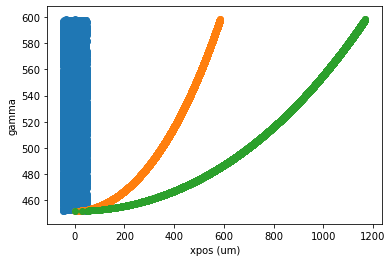

In [177]:
# elegant init path and filename for .ele file that creates the initial distribution
pathele0 = r'D:/Dropbox/py_projects/elegenapi/elegant/particle_dist_generation/'
fileele0 = 'particle_dist_init_lpa.ele'

# filenames of the sdds output from particle manipulations and the distfile filename for input into genesis
sddsout = r'lpaxfel_largedE.sdds'
gendf = sddsout[:-5] + '.distfile'
# genesis input and output filenames
genin = 'lpaxfel.in'
genout = 'lpaxfel_DF1_11'

# genesis uses the relativistic gamma to define e-beam energy
gammagen = 452
# elegant uses p_mev 
gbele = gammabeta(gammagen)
mc2MeV = 1e-6 * pc.m_e * pc.c**2 / pc.e
print('gamma = {:06.4f} \ngamma*beta = {:06.4f}'.format(*[gammagen, gbele] ) )
print('U = gmc2 = {:06.4f} MeV\np = gbmc = {:06.4f} MeV/c'.format(*[gammagen*mc2MeV, gbele*mc2MeV]))

# charge number used in the conversion from SDDS to distfile
equivalentgenesischarge = (5000/240)*1.0e-9


# make changes to genesis input file
gc = ega.GenControl(0)
chparams = {'NWIG':600,
            'PRAD0':1e3,
            'ZRAYL':0.5,
            'DGRID':5e-3,
            'NCAR':251,
            'ZSTOP':-1,
            'IPPART':0,
            'XLAMDS':80.0e-9,
            'NSCAN':1,
            'SCAN':'ZRAYL',
            'SVAR':0.5,
            }
gc.param_set(genin, chparams)

# scanning ascale
apts = 3
alist = np.linspace(0,33e3, apts)
acenter = 33e3
arange = 0.05
# alist = np.linspace((1-arange)*acenter, (1+arange)*acenter, apts)

mpts = 1
momofflist = np.linspace(0,12,mpts)
print(alist)
print(momofflist)
# list of output files
genoutfnlist = []
bcm = 1
for aa in alist:
    for mo in momofflist:
        if mpts == 1:
            genout = 'lpa_a{:06.4e}_mo{:03.1f}'.format(*[aa,mo])
        else:
            genout = 'lpa_a{:06.4e}_mo{:03.2e}'.format(*[aa, mo])

        elegen(pathele0, fileele0, 
               genpath, sddsout, gendf,
               genin, genout,
               bc=True, bcmethod=bcm, aBC=aa, gammaresonant=gammagen, momoffMeV=mo,
               chargegen=equivalentgenesischarge,
               verbose=False,plot=True)
        # add to list of generated output files
        genoutfnlist = genoutfnlist + [genout]
print(genoutfnlist)

In [178]:
# Load that output files for the scans
go11scan = []
for ii in range(len(genoutfnlist)):
    go11scan = go11scan + [ega.GenOut()]
    go11scan[ii].load(genoutfnlist[ii])


Text(0.5, 1.0, 'LPA XFEL: scan of energy offset')

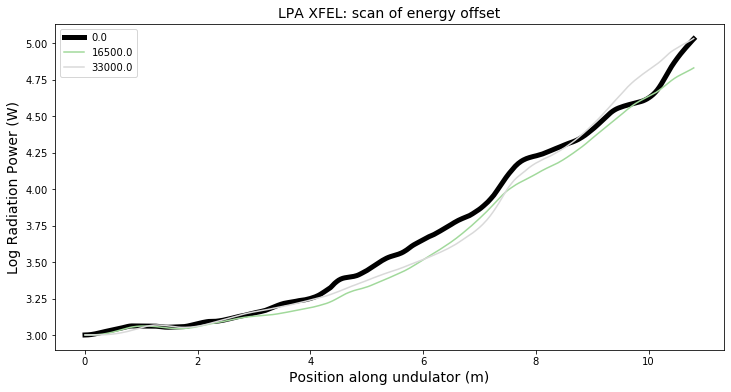

In [179]:
if apts == 1:
    ampts = mpts
    legendlist = momofflist
elif mpts == 1:
    ampts = apts
    legendlist = alist
fig, ax = plt.subplots(figsize=(12,6))
for ii in range(len(genoutfnlist)):
    
    if ii == 0 and True:
        plt.plot(go11scan[ii].data.z, np.log10(go11scan[ii].data.power),color='k',linewidth=5)
    else:
        plt.plot(go11scan[ii].data.z, np.log10(go11scan[ii].data.power), color=mcm.get_cmap('tab20c')(ii%ampts/(ampts-1)))
plt.legend(legendlist)
# plt.axis([0,3.5,0,10])
# plt.grid()
fs = dict(fontsize=14)
plt.xlabel('Position along undulator (m)',**fs)
plt.ylabel('Log Radiation Power (W)', **fs)
plt.title('LPA XFEL: scan of energy offset', fontsize=14)

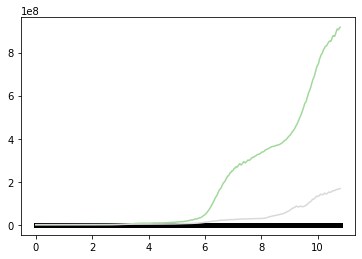

In [161]:
for ii in range(len(genoutfnlist)):
    
    if ii == 0 and True:
        plt.plot(go11scan[ii].data.z, np.log10(go11scan[ii].data.power),color='k',linewidth=5)
    else:
        plt.plot(go11scan[ii].data.z, (go11scan[ii].data.power), color=mcm.get_cmap('tab20c')(ii%ampts/(ampts-1)))


[0.         6.28258466]
lambda_max = 39.8800
[0.         6.37084058]
lambda_max = 39.8800
[0.         8.14405906]
lambda_max = 39.8800


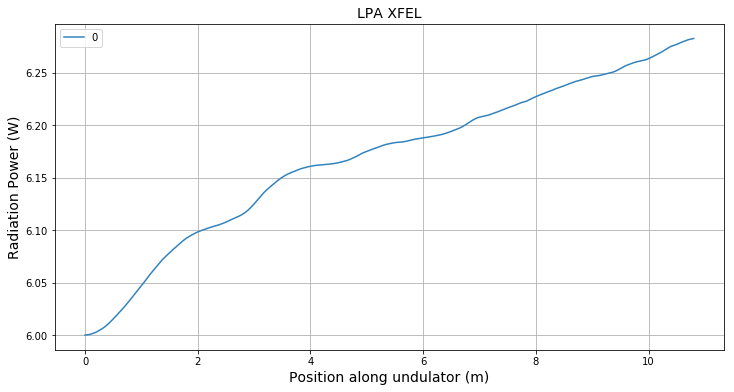

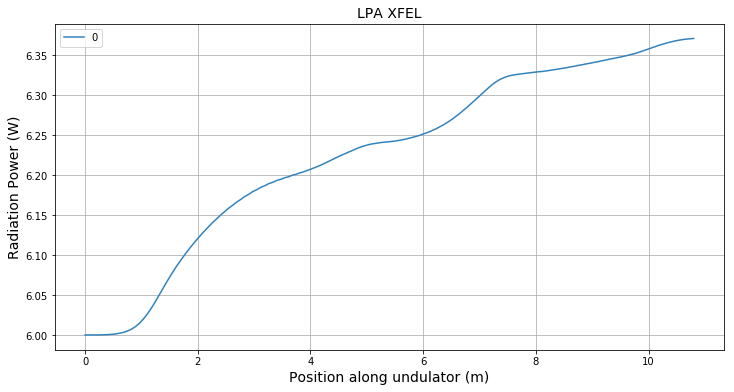

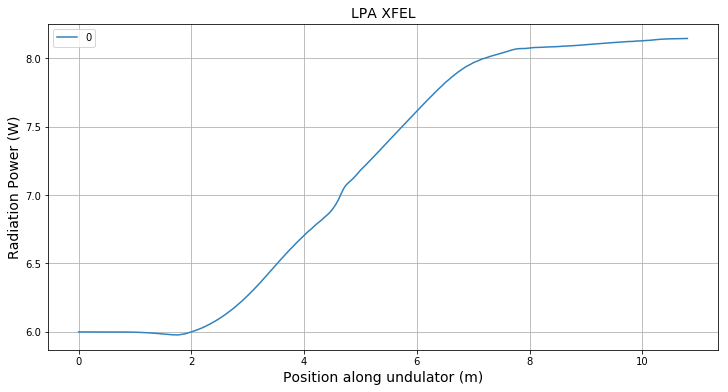

In [16]:
for go in go11scan:
    pwrscan = np.zeros([go.nslice,2])
    fig, ax = plt.subplots(figsize=(12,6))
    for ss in range(go.nslice):
        xvec = go.data[go.data.slice == ss].z
        yvec = np.log10(go.data[go.data.slice == ss].power)
        ax.plot(xvec, yvec, color=mcm.get_cmap('tab20c')(ss / go.nslice))

        plt.grid()

        fs = dict(fontsize=14)
        plt.xlabel('Position along undulator (m)',**fs)
        plt.ylabel('Radiation Power (W)', **fs)
        plt.title('LPA XFEL', fontsize=14)

        pwrscan[ss] = [ss, yvec.max()]
    
    plt.legend(range(go.nslice))
    
    for row in pwrscan:
        print(row)
    sstemp = 0
    lammax = np.float(go.paramsin['XLAMDS'][0]) * (1 - np.float(go.paramsin['SVAR'][0]) + 2 * sstemp * np.float(go.paramsin['SVAR'][0]) / np.float(go.paramsin['NSCAN'][0])) 
    print('lambda_max = {:06.4f}'.format(*[lammax*1e9]))


In [57]:
gradquad = 50
kund = 0.891
a = np.sqrt( (2 * pc.m_e * pc.c) * ( 1 + kund**2 / 2) / (pc.e * gradquad) ) / np.sqrt(gammagen)

In [58]:
a * 1e6

459.0387870812904